# Infosys Springboard Project

## (by Prakarsh Mathur)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
dataset = pd.read_csv("AAPL.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,12/12/1980,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,12/15/1980,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,12/16/1980,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,12/17/1980,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,12/18/1980,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj_Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [6]:
dataset['Date']= pd.to_datetime(dataset['Date'])

In [7]:
dataset = dataset.sort_values('Date').reset_index(drop=True)

In [8]:
dataset.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [9]:
data = dataset.drop(columns=["Date"])

In [10]:
data.head()

,Open,High,Low,Close,Adj_Close,Volume
0,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


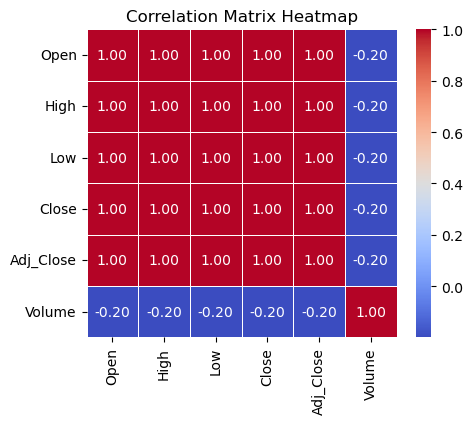

In [11]:
cor = data.corr()
plt.figure(figsize=(5, 4)) 
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [12]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

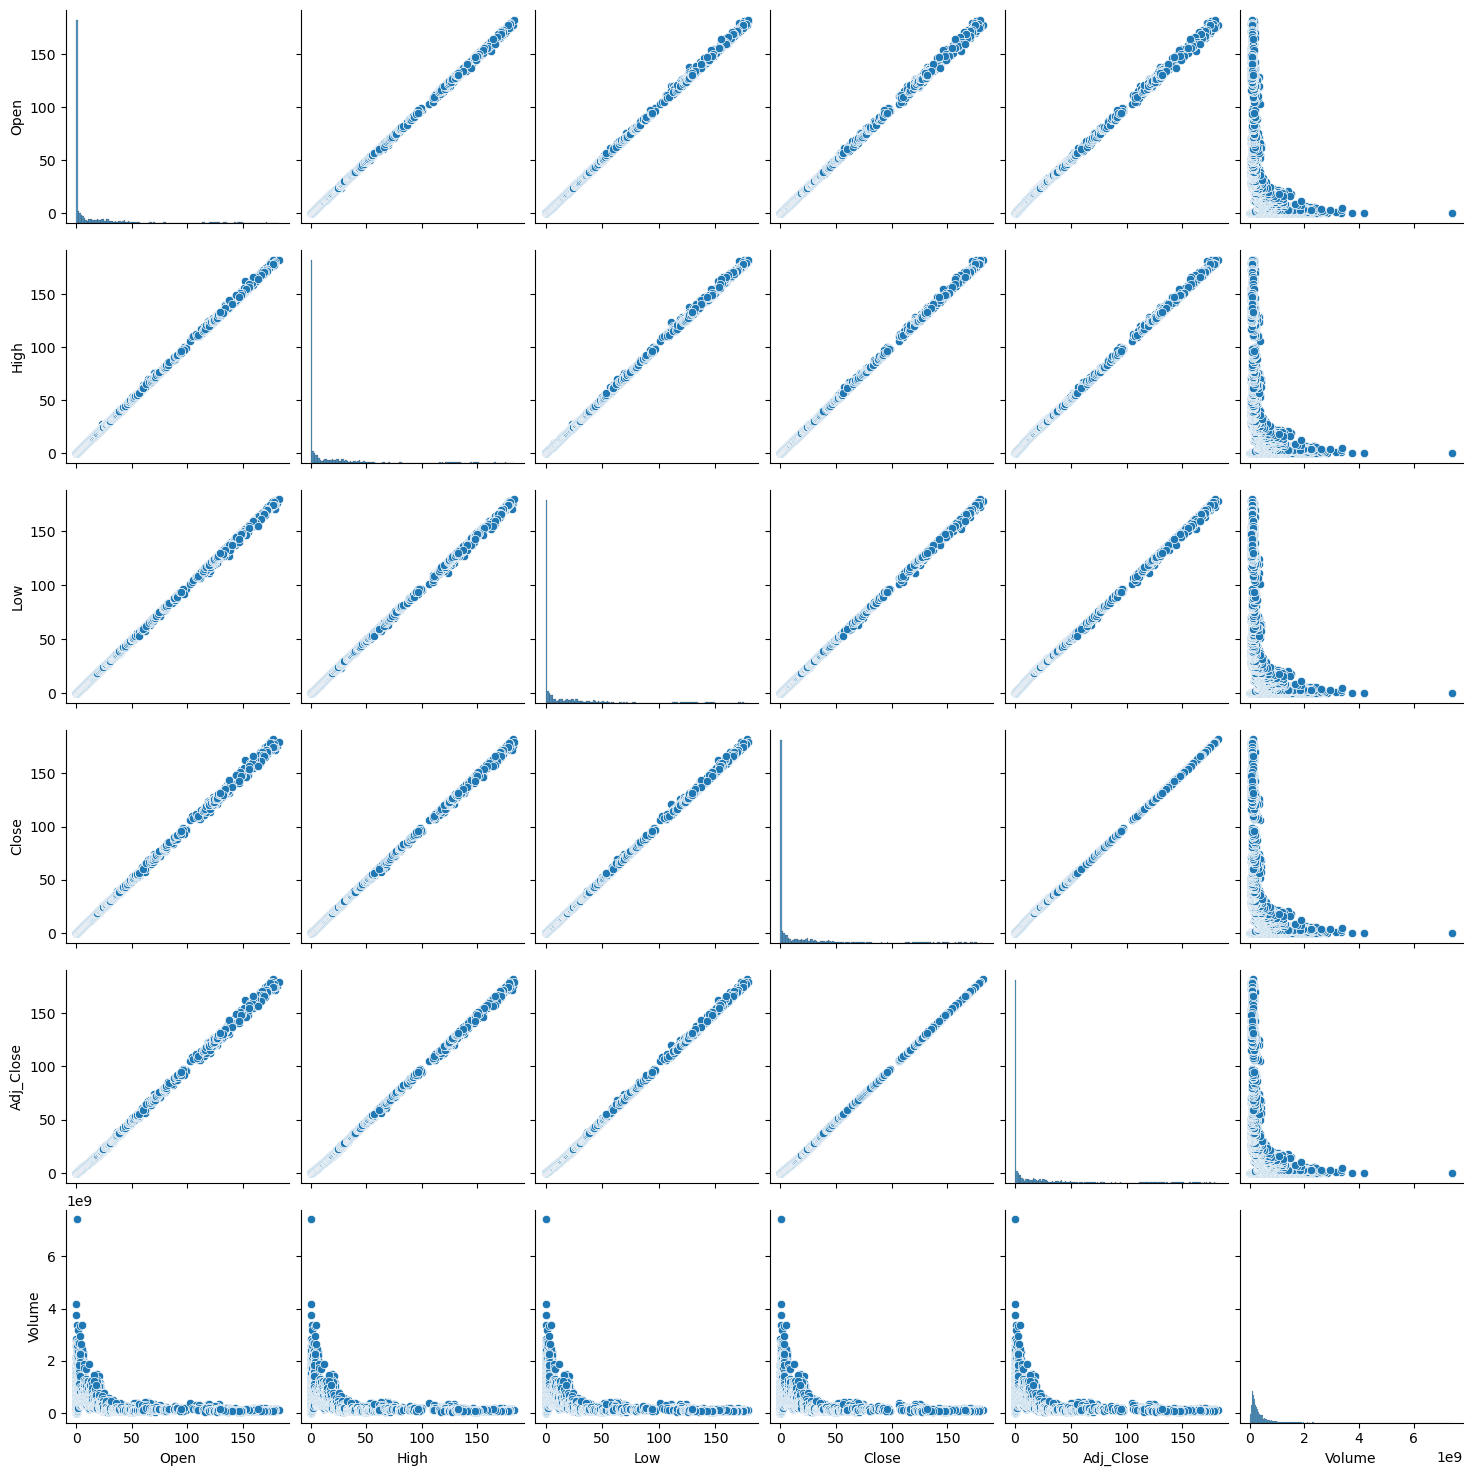

In [13]:
sns.pairplot(data)

In [14]:
def detect_outliers(data, threshold=3):
    z_scores = np.abs(data.apply(zscore)) 
    outliers = (z_scores > threshold).any(axis=1)
    return outliers

outliers = detect_outliers(data)
print("Number of outliers = ", outliers.sum())

Number of outliers =  667


In [15]:
z_scores = np.abs(data.apply(zscore))
data = data[(z_scores < 2).all(axis=1)]

In [16]:
outliers = detect_outliers(data)
print("Number of outliers = ", outliers.sum())

Number of outliers =  341


In [17]:
#sns.pairplot(data)

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

In [19]:
scaled_data.head()

,Open,High,Low,Close,Adj_Close,Volume
0,0.001009,0.001004,0.001025,0.001019,0.000808,0.465790
1,0.000930,0.000919,0.000938,0.000933,0.000740,0.174668
2,0.000816,0.000806,0.000823,0.000818,0.000649,0.104997
3,0.000844,0.000841,0.000859,0.000854,0.000677,0.085844
4,0.000887,0.000884,0.000902,0.000897,0.000711,0.072942


In [20]:
target = data['Adj_Close'].values.reshape(-1, 1)

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target)

In [22]:
def create_sequences(data, sequence):
    X, y = [], []
    for i in range(len(data) - sequence):
        X.append(data[i:i + sequence])
        y.append(data[i + sequence])
    return np.array(X), np.array(y)

sequence = 30
X, y = create_sequences(scaled_data, sequence)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [24]:
from keras.optimizers import Adam

In [25]:
model = Sequential([
    LSTM(32, activation='relu', input_shape=(sequence, 1)),
    Dropout(0.2),
    Dense(1)
])
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mse')


In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          
    restore_best_weights=True  
)

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping]) #training the model

Epoch 1/100
103/103 [==============================] - 3s 17ms/step - loss: 4.3007e-05 - val_loss: 0.0017
Epoch 2/100
103/103 [==============================] - 1s 13ms/step - loss: 1.0030e-05 - val_loss: 0.0147
Epoch 3/100
103/103 [==============================] - 1s 13ms/step - loss: 9.2531e-06 - val_loss: 0.0025
Epoch 4/100
103/103 [==============================] - 1s 13ms/step - loss: 7.3006e-06 - val_loss: 0.0015
Epoch 5/100
103/103 [==============================] - 1s 14ms/step - loss: 7.8949e-06 - val_loss: 0.0025
Epoch 6/100
103/103 [==============================] - 1s 14ms/step - loss: 9.0111e-06 - val_loss: 5.3146e-04
Epoch 7/100
103/103 [==============================] - 1s 13ms/step - loss: 6.2429e-06 - val_loss: 2.3204e-04
Epoch 8/100
103/103 [==============================] - 1s 13ms/step - loss: 7.1199e-06 - val_loss: 0.0047
Epoch 9/100
103/103 [==============================] - 1s 13ms/step - loss: 7.5327e-06 - val_loss: 0.0015
Epoch 10/100
103/103 [================

In [28]:
predictions = model.predict(X_test)

89/89 [==============================] - 1s 5ms/step


In [29]:
rescaled_pred = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

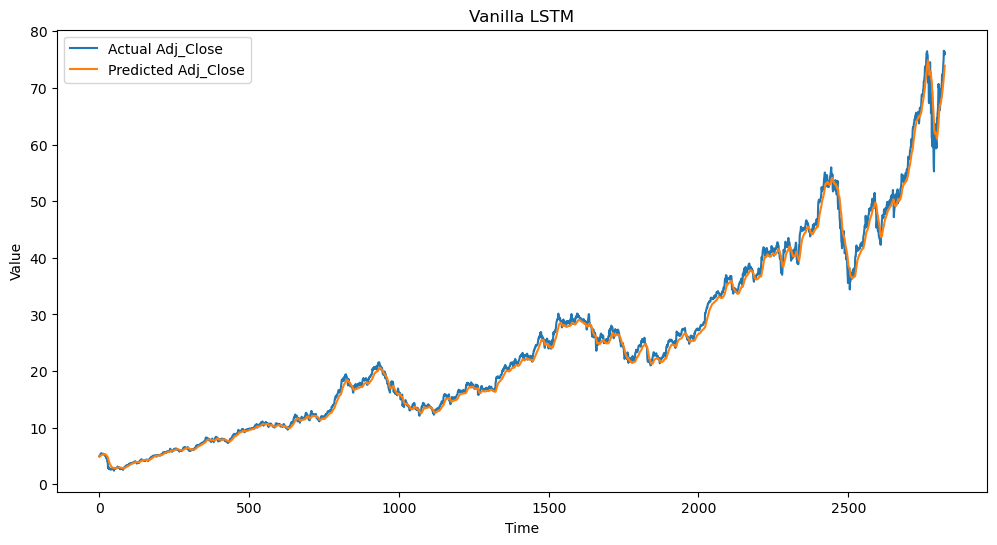

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Adj_Close')
plt.plot(rescaled_pred, label='Predicted Adj_Close')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Vanilla LSTM')
plt.legend()
plt.show()

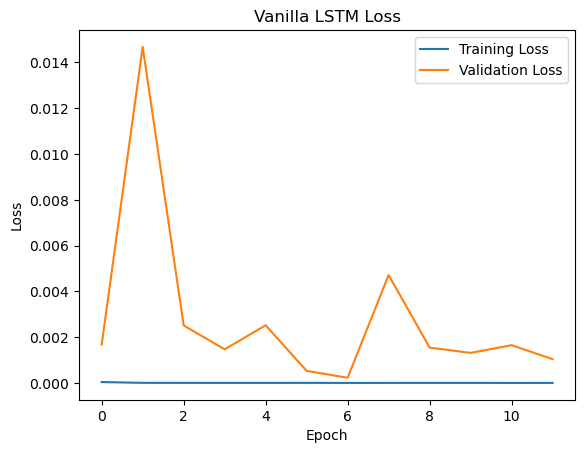

In [31]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Vanilla LSTM Loss')
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_rescaled, rescaled_pred)
mse = mean_squared_error(y_test_rescaled, rescaled_pred)
r2 = r2_score(y_test_rescaled, rescaled_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.7981
Mean Squared Error (MSE): 1.3593
R² Score: 0.9949


### Stacked LSTM

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [35]:
model2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='mse') # compiling the model

In [44]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
103/103 [==============================] - 6s 60ms/step - loss: 7.1103e-06 - val_loss: 0.0404
Epoch 2/100
103/103 [==============================] - 6s 62ms/step - loss: 7.2070e-06 - val_loss: 0.0186
Epoch 3/100
103/103 [==============================] - 6s 62ms/step - loss: 6.7553e-06 - val_loss: 0.0278
Epoch 4/100
103/103 [==============================] - 6s 61ms/step - loss: 5.2646e-06 - val_loss: 0.0224
Epoch 5/100
103/103 [==============================] - 6s 62ms/step - loss: 4.2725e-06 - val_loss: 0.0362
Epoch 6/100
103/103 [==============================] - 7s 66ms/step - loss: 5.1778e-06 - val_loss: 0.0393
Epoch 7/100
103/103 [==============================] - 8s 76ms/step - loss: 4.8792e-06 - val_loss: 0.0351


In [39]:
predictions2 = model2.predict(X_test)

89/89 [==============================] - 1s 14ms/step


In [40]:
rescaled_pred2 = scaler.inverse_transform(predictions2.reshape(-1, 1))
y_test_rescaled2 = scaler.inverse_transform(y_test.reshape(-1, 1))

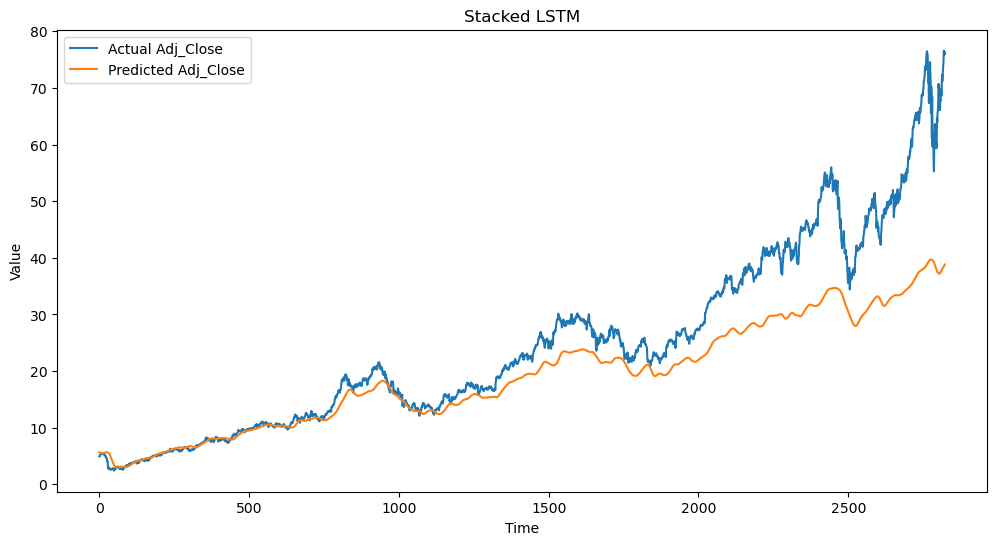

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled2, label='Actual Adj_Close')
plt.plot(rescaled_pred2, label='Predicted Adj_Close')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Stacked LSTM')
plt.legend()
plt.show()

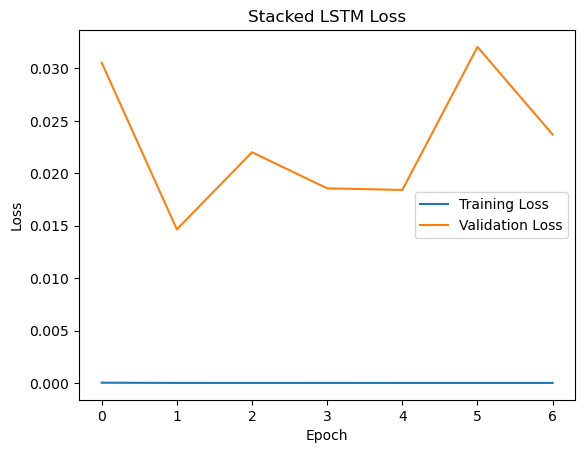

In [42]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Stacked LSTM Loss')
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_rescaled2, rescaled_pred2)
mse = mean_squared_error(y_test_rescaled2, rescaled_pred2)
r2 = r2_score(y_test_rescaled2, rescaled_pred2)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 5.75910190611359
Mean Squared Error (MSE): 85.84844409642511
R² Score: 0.674856196398022


### Bi-directional LSTM

In [45]:
from keras.layers import Bidirectional

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
model3 = Sequential([
    Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(sequence, 1)),
    Bidirectional(LSTM(50, activation='relu')),
    Dense(1)
])

model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [49]:
history = model3.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
118/118 [==============================] - 15s 61ms/step - loss: 0.0025 - mae: 0.0181 - val_loss: 1.7448e-04 - val_mae: 0.0076
Epoch 2/100
118/118 [==============================] - 6s 47ms/step - loss: 1.2076e-04 - mae: 0.0051 - val_loss: 1.4677e-04 - val_mae: 0.0072
Epoch 3/100
118/118 [==============================] - 6s 48ms/step - loss: 1.1530e-04 - mae: 0.0053 - val_loss: 1.8657e-04 - val_mae: 0.0070
Epoch 4/100
118/118 [==============================] - 6s 48ms/step - loss: 1.1222e-04 - mae: 0.0058 - val_loss: 1.1174e-04 - val_mae: 0.0050
Epoch 5/100
118/118 [==============================] - 6s 53ms/step - loss: 1.0129e-04 - mae: 0.0055 - val_loss: 7.2562e-05 - val_mae: 0.0037
Epoch 6/100
118/118 [==============================] - 7s 63ms/step - loss: 8.2882e-05 - mae: 0.0048 - val_loss: 7.2604e-05 - val_mae: 0.0042
Epoch 7/100
118/118 [==============================] - 7s 61ms/step - loss: 9.0047e-05 - mae: 0.0050 - val_loss: 6.0719e-05 - val_mae: 0.0040
Epoch 8/1

In [50]:
predictions3 = model3.predict(X_test)

59/59 [==============================] - 1s 10ms/step


In [51]:
rescaled_pred3 = scaler.inverse_transform(predictions3.reshape(-1, 1))
y_test_rescaled3 = scaler.inverse_transform(y_test.reshape(-1, 1))

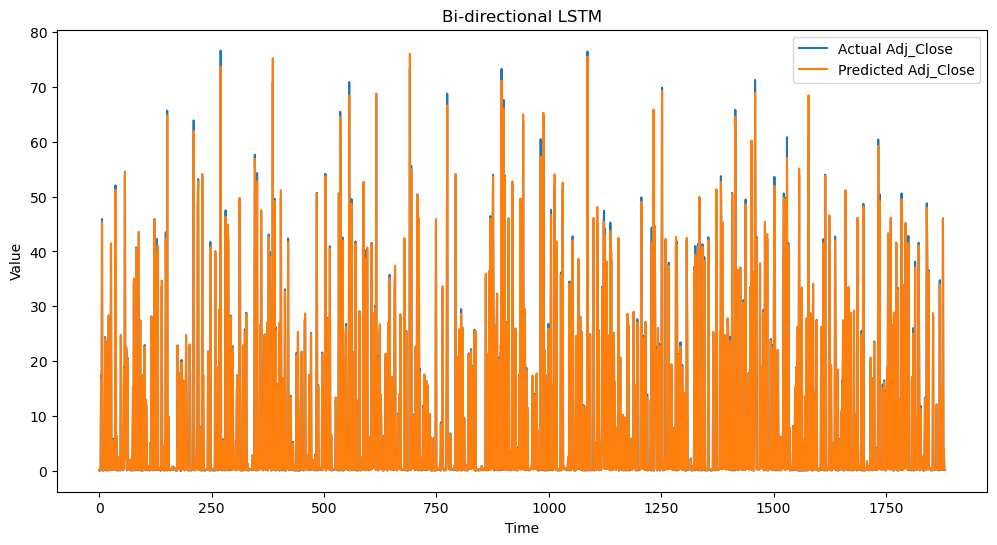

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled3, label='Actual Adj_Close')
plt.plot(rescaled_pred3, label='Predicted Adj_Close')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Bi-directional LSTM')
plt.legend()
plt.show()

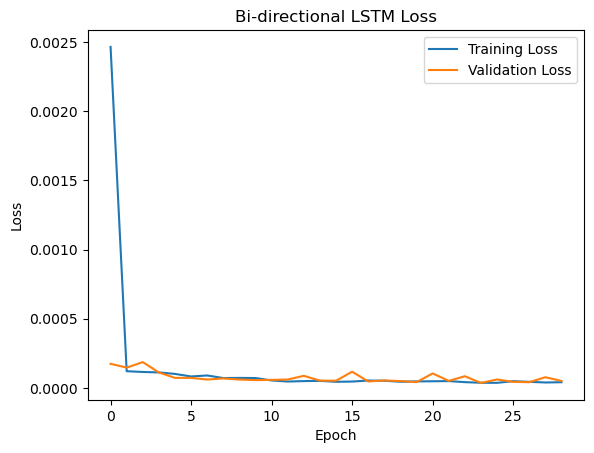

In [53]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Bi-directional LSTM Loss')
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_rescaled3, rescaled_pred3)
mse = mean_squared_error(y_test_rescaled3, rescaled_pred3)
r2 = r2_score(y_test_rescaled3, rescaled_pred3)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.1874657116063221
Mean Squared Error (MSE): 0.21200227650125736
R² Score: 0.9990166041238948


### Convolutional LSTM

In [55]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

In [56]:
model4 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(1)
])

In [57]:
model4.compile(optimizer='adam', loss='mse')

In [58]:
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
118/118 [==============================] - 6s 34ms/step - loss: 0.0047 - val_loss: 1.1366e-04
Epoch 2/100
118/118 [==============================] - 2s 21ms/step - loss: 8.9725e-05 - val_loss: 7.9574e-05
Epoch 3/100
118/118 [==============================] - 2s 13ms/step - loss: 7.2493e-05 - val_loss: 7.2796e-05
Epoch 4/100
118/118 [==============================] - 4s 30ms/step - loss: 8.0349e-05 - val_loss: 8.8199e-05
Epoch 5/100
118/118 [==============================] - 2s 20ms/step - loss: 7.5086e-05 - val_loss: 8.1396e-05
Epoch 6/100
118/118 [==============================] - 4s 30ms/step - loss: 6.7229e-05 - val_loss: 6.1094e-05
Epoch 7/100
118/118 [==============================] - 2s 19ms/step - loss: 8.1775e-05 - val_loss: 1.0231e-04
Epoch 8/100
118/118 [==============================] - 2s 20ms/step - loss: 6.0593e-05 - val_loss: 6.4662e-05
Epoch 9/100
118/118 [==============================] - 3s 22ms/step - loss: 5.8855e-05 - val_loss: 5.6693e-05
Epoch 10/100
1

In [59]:
predictions4 = model4.predict(X_test)

59/59 [==============================] - 0s 3ms/step


In [60]:
rescaled_pred4 = scaler.inverse_transform(predictions4.reshape(-1, 1))
y_test_rescaled4 = scaler.inverse_transform(y_test.reshape(-1, 1))

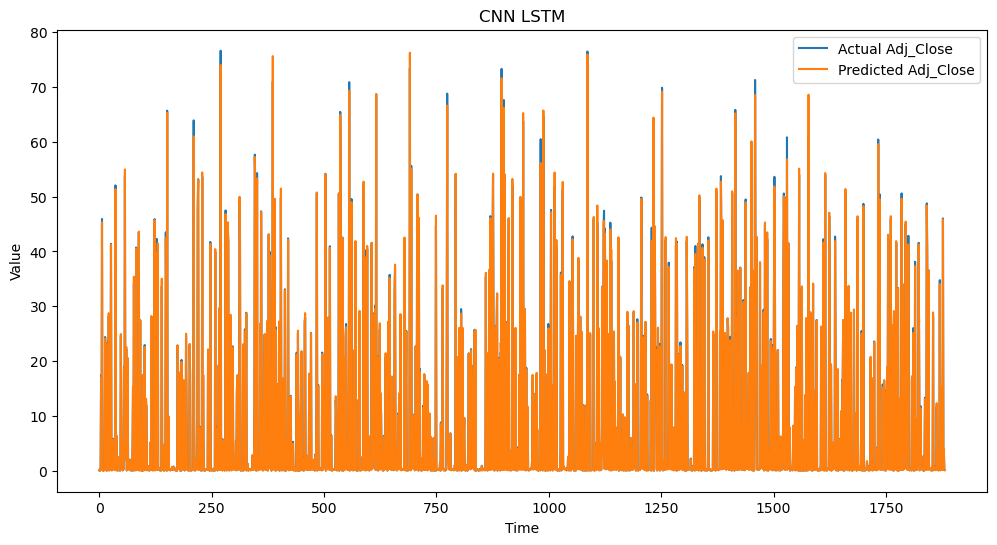

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled4, label='Actual Adj_Close')
plt.plot(rescaled_pred4, label='Predicted Adj_Close')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('CNN LSTM')
plt.legend()
plt.show()

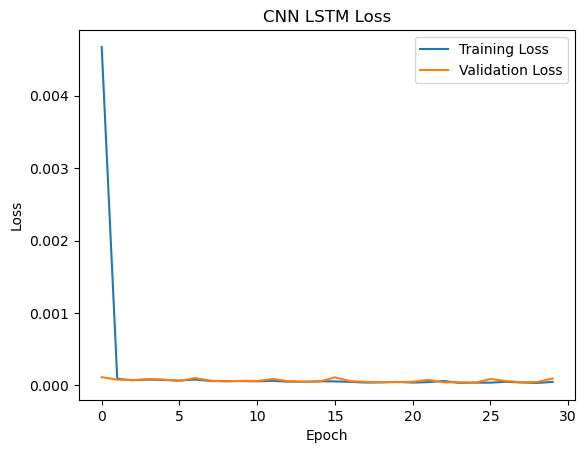

In [62]:
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN LSTM Loss')
plt.show()

In [63]:
mae = mean_absolute_error(y_test_rescaled4, rescaled_pred4)
mse = mean_squared_error(y_test_rescaled4, rescaled_pred4)
r2 = r2_score(y_test_rescaled4, rescaled_pred4)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.1769
MSE: 0.2177
R² Score: 0.9990
